# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation import maximum_independent_set as mis
from time import time

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

In [3]:
from utils import generate_graph, get_gnn_2, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

### Problem-specific (MIS) utilities

In [4]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

# Step 2 - Set hyperparameters

In [5]:
# # Graph hypers
# n = 500
# d = 3
# p = None
# graph_type = 'reg'

# NN learning hypers #
number_epochs = 50_000 #int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 100

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# Step 1 - Build correlation matrix

In [6]:
import pandas as pd

In [7]:
sp500_hist = pd.read_csv(
    "sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

# drop columns with more than 60% NaN values
sp500_hist.dropna(axis=1, thresh=int(len(sp500_hist)*0.4), inplace=True)

# drop columns with negative values in it
sp500_hist.drop(
    columns=sp500_hist.columns[(sp500_hist < 0).any()].values, 
    axis=1,
    inplace=True)

# reduce dataset
sp500_hist = sp500_hist.iloc[:,:n]

print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (4279, 100)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,20.439508,35.305668,38.559849,2.272182,NaN,16.348289,12.590348,6.120000,21.528095,38.520000,...,35.615826,23.690931,18.372643,35.133659,34.607559,6.503965,40.591961,NaN,15.688561,8.672225
2006-01-04,20.494427,36.955471,38.834522,2.278869,NaN,16.239967,12.609449,6.151111,21.645647,38.419998,...,36.418205,23.975861,18.590128,35.367283,34.907948,6.541159,40.007172,NaN,16.494829,8.630507
2006-01-05,21.031340,37.436260,39.020573,2.260936,NaN,16.038809,12.771802,6.061111,21.807291,38.070000,...,36.960541,23.785910,18.312412,35.539413,35.118244,6.551074,40.700439,NaN,16.263483,8.588784
2006-01-06,21.141167,36.766926,38.976273,2.319297,NaN,15.860854,13.016929,6.173333,22.887375,39.000000,...,37.103252,24.007519,18.342529,36.098862,34.625587,6.764320,41.924820,NaN,16.453394,8.713952
2006-01-09,21.080151,36.399242,39.481319,2.311697,NaN,15.860854,13.500801,6.116667,22.821247,38.380001,...,36.602150,23.923098,18.560015,36.369350,34.853893,6.806474,42.601284,NaN,16.617411,8.660311


In [8]:
METHOD = 'pct'

if METHOD == 'standard':
    df_corr = sp500_hist.corr(method='pearson').abs()
elif METHOD == 'pct':
    sp500_pct = sp500_hist.pct_change()
    sp500_pct = sp500_pct.groupby(sp500_pct.index.year).sum()
    df_corr = sp500_pct.corr(method='pearson').abs()
else:
    raise KeyError("METHOD must be either 'standard' or 'pct'")

df_corr

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS
A,1.000000,0.060148,0.157241,0.768849,0.296156,0.650578,0.280147,0.065514,0.525189,0.790364,...,0.824771,0.341412,0.515821,0.461494,0.759111,0.233104,0.812799,0.475330,0.649191,0.802507
AAL,0.060148,1.000000,0.224094,0.215877,0.164439,0.274348,0.071334,0.097154,0.294366,0.025244,...,0.088075,0.449693,0.019758,0.108657,0.439672,0.745109,0.030717,0.238632,0.010194,0.046219
AAP,0.157241,0.224094,1.000000,0.165893,0.082694,0.154293,0.043957,0.207145,0.259158,0.164824,...,0.085964,0.427648,0.165603,0.024653,0.308062,0.100291,0.263149,0.495929,0.109742,0.219398
AAPL,0.768849,0.215877,0.165893,1.000000,0.003183,0.427384,0.358726,0.077663,0.506498,0.652120,...,0.588266,0.074929,0.659773,0.388924,0.420822,0.056286,0.641788,0.698130,0.741920,0.723411
ABBV,0.296156,0.164439,0.082694,0.003183,1.000000,0.438390,0.375691,0.005438,0.133962,0.328067,...,0.240080,0.090577,0.228828,0.284973,0.318452,0.040991,0.230848,0.070775,0.004424,0.023283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMCSA,0.233104,0.745109,0.100291,0.056286,0.040991,0.156501,0.229514,0.212731,0.611984,0.328143,...,0.009635,0.527627,0.390277,0.416855,0.407037,1.000000,0.136742,0.003916,0.105297,0.224345
CME,0.812799,0.030717,0.263149,0.641788,0.230848,0.377542,0.350734,0.086242,0.417267,0.777847,...,0.728397,0.298355,0.384978,0.421706,0.653574,0.136742,1.000000,0.441501,0.532931,0.732791
CMG,0.475330,0.238632,0.495929,0.698130,0.070775,0.359048,0.256804,0.036164,0.227830,0.303238,...,0.301460,0.104297,0.406377,0.237969,0.123803,0.003916,0.441501,1.000000,0.624972,0.481008
CMI,0.649191,0.010194,0.109742,0.741920,0.004424,0.329396,0.101012,0.114708,0.174294,0.274599,...,0.449691,0.113691,0.482883,0.103265,0.544920,0.105297,0.532931,0.624972,1.000000,0.546622


In [9]:
df_corr.describe()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.519264,0.206139,0.202661,0.463002,0.244729,0.384263,0.268150,0.198270,0.437621,0.471245,...,0.406404,0.323005,0.397137,0.313719,0.459362,0.291509,0.466959,0.321705,0.383137,0.448092
std,0.247196,0.185376,0.149216,0.237731,0.177365,0.186010,0.182810,0.171655,0.215088,0.221409,...,0.237859,0.188066,0.195135,0.189667,0.211510,0.190964,0.230306,0.190060,0.235838,0.243360
min,0.002699,0.000118,0.000926,0.003183,0.003183,0.042042,0.001565,0.003437,0.026388,0.013110,...,0.002643,0.000788,0.004837,0.000666,0.004158,0.003916,0.030717,0.003916,0.004424,0.012488
25%,0.290698,0.061299,0.100482,0.289140,0.098434,0.266271,0.129594,0.069494,0.259116,0.319354,...,0.188245,0.184537,0.291860,0.162598,0.306380,0.135835,0.274708,0.166511,0.160540,0.266766
50%,0.555366,0.147262,0.185994,0.459276,0.229143,0.386775,0.241836,0.145244,0.484529,0.487422,...,0.430770,0.311018,0.403397,0.311035,0.477589,0.266195,0.514817,0.306998,0.407436,0.469488
75%,0.706246,0.309782,0.264376,0.659079,0.337788,0.497471,0.372544,0.290886,0.602048,0.640221,...,0.588402,0.455223,0.528467,0.437667,0.605250,0.413432,0.655955,0.438071,0.545345,0.631427
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df_corr.quantile(0.5).mean()

0.36768940842847636

In [11]:
df_corr.where(df_corr >= 0.5).count().sum(), df_corr.where(df_corr < 0.5).count().sum()

(2876, 7124)

In [12]:
# df_corr.hist()

In [13]:
# d = 90

# df_corr = df_corr.apply(lambda x: np.where(x >= x.sort_values(ascending=False)[5], 1, 0))
# df_corr

# Step 3 - Generate Graph

In [14]:
def build_nx_graph(df_corr:pd.DataFrame, threshold:float) -> nx.Graph:
    """ Returns a Networkx.Graph from a correlation matrix.
        Args:
            df_corr (pd.DataFrame): Correlation matrix
            threshold (float): edges with an correlation coefficient smaller
                than the treshold will be removed. 
                Note: The treshold bust be choosen reasonalbe, the graph must
                not be disconnected.
        Returns:
            nx.Graph
    """
    cor_matrix = df_corr.values.astype('float')
    sim_matrix = 1 - cor_matrix
    G = nx.from_numpy_array(sim_matrix)

    stock_names = df_corr.index.values
    # G = nx.relabel_nodes(G, lambda x: stock_names[x])
    # G.edges(data=True)
    H = G.copy()

    for (u, v, wt) in G.edges.data('weight'):

        if wt >= 1 - threshold:
            H.remove_edge(u, v)

        if u == v:
            H.remove_edge(u, v)

    return H

In [15]:
# cor_matrix = df_corr.values.astype('float')
# sim_matrix = 1 - cor_matrix
# sim_matrix
# # G = nx.from_numpy_array(sim_matrix)
# # # G.edges
# # H = G.copy()

# # for (u, v, wt) in H.edges.data('weight'):

# #     if wt == 0.0:
# #         H.remove_edge(u, v)

# # #     if u == v:
# # #         H.remove_edge(u, v)

# # H.edges.data('weight')

In [16]:
nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=0.5
)

assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'

In [17]:
(2876-100)/2

1388.0

In [18]:
len(nx_graph.edges)

1388

In [19]:
# Constructs a random d-regular or p-probabilistic graph
# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

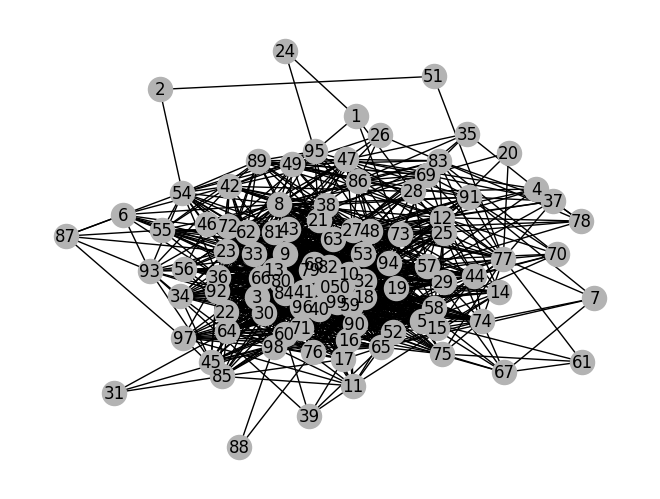

In [20]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [21]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.05,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn_2(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

# Step 4 - Run GNN training

In [22]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring, embed = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 816.7457275390625


c:\Users\roman\Documents\20_Git_workspace\VP2\VP2-co-with-gnns-example\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch: 1000, Loss: 374.7052001953125
Epoch: 2000, Loss: 118.06575012207031
Epoch: 3000, Loss: 39.177452087402344
Epoch: 4000, Loss: 13.429417610168457
Epoch: 5000, Loss: 4.2155938148498535
Epoch: 6000, Loss: 2.288285255432129
Epoch: 7000, Loss: 1.0925023555755615
Epoch: 8000, Loss: 0.4642590582370758
Epoch: 9000, Loss: 0.29829367995262146
Epoch: 10000, Loss: -0.2428450882434845
Epoch: 11000, Loss: -0.10988795757293701
Epoch: 12000, Loss: -0.165048748254776
Epoch: 13000, Loss: -0.19864292442798615
Epoch: 14000, Loss: -0.2075689136981964
Epoch: 15000, Loss: -0.2234751582145691
Epoch: 16000, Loss: -1.0070891380310059
Epoch: 17000, Loss: -4.800056457519531
Epoch: 18000, Loss: -7.506786346435547
Epoch: 19000, Loss: -10.900750160217285
Epoch: 20000, Loss: -9.725014686584473
Epoch: 21000, Loss: -11.23595905303955
Epoch: 22000, Loss: -10.211949348449707
Epoch: 23000, Loss: -11.387127876281738
Epoch: 24000, Loss: -11.374597549438477
Epoch: 25000, Loss: -10.926088333129883
Epoch: 26000, Loss: -1

# Step 5 - Post-process GNN results

In [ ]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 18 with 0 violations
Took 417.577s, model training took 408.165s


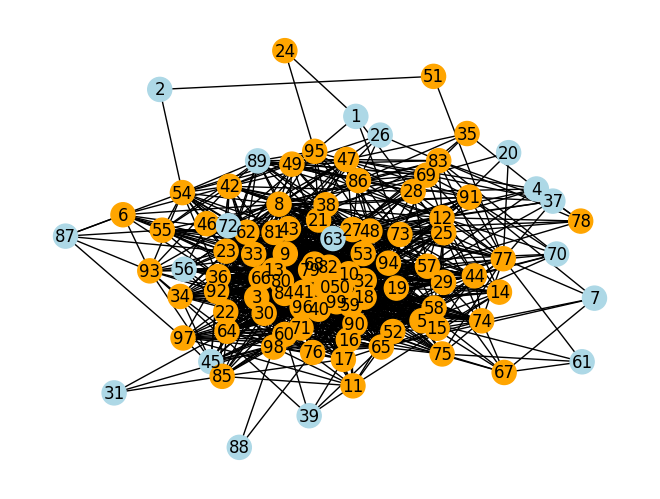

In [ ]:
# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

# Step 6 - (optional) Compare to classical solver

In [ ]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 19 with 0 violations.
MIS solver took 0.118s


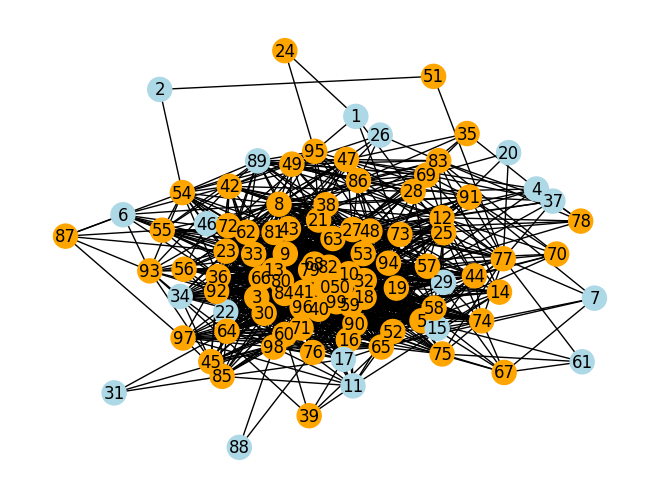

In [ ]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)